# 2R Roboter

## Simulation nichtlineares Modell ohne Eingang

In [ ]:
"""
Date: 20.12.2022
Author: Kaufmann Stefan

Robot Control - Simulation 2R Roboter 
"""
# Load Robotermodell
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin, model_nlin_ext
import importlib as imp

def eingang(x,t,k=[1,1]):
    """ System Input
        Params
         --------
        x:             steady states as [x1,x2]
        t:             time as int
        k:             Controler Gain k = [k1,k2]   mit k1,k2 > 0       
                              

        Returns
        --------
        u:              System input   
                
    """
    k1 = k[0]
    k2 = k[1]
    x1 = x[0]
    x2 = x[1]

    #u = -k2*(x2+k1)-x1-x1**2  # Version 1
    u = -k2*(x2+k1*(x1**2)) - x1 -x1**2 -2*k1*x1**2*(x2+k1*x1**2)

    return u 



In [ ]:
from Model import model_nlin, model_nlin_ext
# set the initial conditions
x0=[-np.pi/2*0,0,0,np.pi/4]

# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim=np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))


#scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)

#solutionOde=odeint(model_nlin,x0,t_sim)
solOde=solve_ivp(model_nlin,[t_start,t_stop],x0,method = 'RK45',t_eval = t_sim)


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[2]*180/np.pi, 'g', label='q_2')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t)')
plt.grid()
#plt.savefig('simulation.png')
plt.show()

In [ ]:
import Animation as anim

q1 = solOde.y[0]
q2 = solOde.y[2]
anim.plot(q1,q2,dt)


# Vorsteuerung

In [ ]:
from Vorsteuerung import *
#from Parameter  import *

u = flat_output(t_stop,t_sim,3,x0[0],0)

plt.plot(t_sim,u[0,:])
plt.plot(t_sim,u[1,:])
plt.plot(t_sim,u[2,:])
plt.legend(['q','q_d','q_dd'])
plt.grid()
plt.show()





## Multivariable Control (Inverse Dynamik)

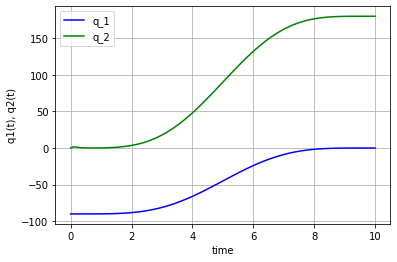

In [1]:
import Animation as anim
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin, model_nlin_ext
from Vorsteuerung import *

x0=[-np.pi/2,0,0,np.pi/4]       # x0 = [q1,q2,qd1,qd2]

# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim=np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))

# Define the controller
class Controller:
  def __init__(self,u,t_sim):
    import sympy as sym
    from Vorsteuerung import flat_output
    self.w1 = 10
    self.w2 = 10
    self.ctr = 'multivariable'
    self.k0 = sym.Matrix([[self.w1**2, 0],[0, self.w2**2]])
    self.k1 = sym.Matrix([[2*self.w1, 0],[0, 2*self.w2]])
    self.u  = u
    self.t  = t_sim

# Define the input vector
u1 = flat_output(t_stop,t_sim,3,x0[0],0)
u2 = flat_output(t_stop,t_sim,3,0,np.pi)

u= np.vstack((u1[0,:],u2[0,:],u1[1,:],u2[1,:],u1[2,:],u2[2,:]))

controller = Controller(u,t_sim)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin_ext(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t)')
plt.grid()
#plt.savefig('simulation.png')
plt.show()

q1 = solOde.y[0]
q2 = solOde.y[1]
anim.plot(q1,q2,dt)
